In [1]:
#Compute RMS of the errors in plot 3

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import erfinv, erf
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [3]:
# #Chicago
# LAT        = 41.8781
# LON        = 360-87.6298
# # #Bengaluru:
LAT        = 12.9716
LON        = 77.5946
########## CONUS ############
#CONUS lat-lon
top     = 50.0 # north lat
left    = -124.7844079+360 # west long
right   = -66.9513812+360 # east long
bottom  =  24.7433195 # south lat
################################
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
loc        = 'Bengaluru/'
locn       = 'Bengaluru'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
## Change/Check these parameters before running
season     = 'JJA'
season0    = 'jja'
months     = [6,7,8]
day        =  2111      #First day of the season
Day        = 'Jul30'

In [2]:
# with dask.config.set(**{'array.slicing.split_large_chunks': False})

SyntaxError: invalid syntax (455136252.py, line 1)

In [4]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [5]:
def gauss_quantile(mean,std,quantile):
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

In [6]:
def mean_adj(ds_stack,ds_mroll):
    ds = (ds_stack - ds_stack.mean(dim='mtime')) + ds_mroll
    return ds

def mean_std_adj(ds_stack,ds_mroll,ds_sroll):
    ds = (ds_stack -ds_stack.mean(dim='mtime'))*(ds_sroll/ds_stack.std(dim='mtime'))\
          + ds_mroll
    return ds

In [7]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(5)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39607 instead
  warnings.warn(


In [8]:
cluster

In [9]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
pi_year  = 1865
ic_year  = 2085
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [10]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 1.96 s, sys: 419 ms, total: 2.38 s
Wall time: 8.53 s


In [11]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw

CPU times: user 226 ms, sys: 1.03 ms, total: 227 ms
Wall time: 221 ms


,Array,Chunk
Bytes,225.56 GiB,769.92 MiB
Shape,"(10950, 192, 288, 100)","(3650, 192, 288, 1)"
Count,2001 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [12]:
%%time
tgw_trim     = tgw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) #Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1)) #Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
tgmw

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

CPU times: user 1.78 s, sys: 54.8 ms, total: 1.83 s
Wall time: 1.78 s


,Array,Chunk
Bytes,451.13 GiB,205.99 MiB
Shape,"(21900, 192, 288, 100)","(900, 20, 30, 100)"
Count,57502 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [13]:
%%time
tgmw_season  = tgmw.sel(time=tgmw.time.dt.month.isin(months))
tgmw_season

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


CPU times: user 136 ms, sys: 5.53 ms, total: 142 ms
Wall time: 135 ms


,Array,Chunk
Bytes,113.71 GiB,63.17 MiB
Shape,"(5520, 192, 288, 100)","(276, 20, 30, 100)"
Count,60002 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [14]:
def stacker(x):
    #Assumes that x has dimensions year and member
    x = x.stack(ym=('year','member'),create_index=False)
    return x
def stacker2(x):
    #Assumes that x has dimensions year and member
    x = x.stack(mtime=('year','member'),create_index=False)
    return x

In [15]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [16]:
def stack_roll(ds,roll_len,stride_len):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds)
    print(ds_stack)
    ds_roll    = ds_stack.rolling(ym=roll_len, center=True).construct('index', stride=stride_len)
    
    return ds_roll   

In [17]:
%%time
tgmw_dseason = to_daily(tgmw_season)
tgmw_dseason = tgmw_dseason.chunk({'year':60,'day':5})
tgmw_dseason

CPU times: user 585 ms, sys: 21.5 ms, total: 606 ms
Wall time: 590 ms


,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 100, 60, 92)","(20, 30, 100, 60, 5)"
Count,86402 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [18]:
%%time
#Save files
dseason_path = cvals+'tgmw_'+season0+'_daily'+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(dseason_path)
# ##### season ###########
#tgmw_dseason.to_dataset().to_zarr(dseason_path,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/tgmw_jja_daily_1850_2100.zarr
CPU times: user 148 µs, sys: 18 µs, total: 166 µs
Wall time: 147 µs


In [19]:
tgmw_dseason = xr.open_zarr(dseason_path)
tgmw_dseason = tgmw_dseason.TREFHTMX
tgmw_dseason

,Array,Chunk
Bytes,113.71 GiB,68.66 MiB
Shape,"(192, 288, 100, 60, 92)","(20, 30, 100, 60, 5)"
Count,1901 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [20]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
quants             = np.arange(0,1.01,0.01)
#tgmw_djulstack     = tgmw_djul.stack(ym=('year','member'),create_index=False)
#tgmw_julrndrop    = stack_roll_ndrop(tgmw_djul,N_mem*window_len,N_mem,15,251-14)
########################
N_mem              = 100
window_len         = 30
###### season #######
#r = roll, ndrop = drop NANs
tgmw_seasonroll     = stack_roll(tgmw_dseason,N_mem*window_len,N_mem)
#########
#tgmw_djulconstruct = tgmw_djulstack.rolling(ym=N_mem*window_len, center=True)\
##.construct('index', stride=N_mem)
tgmw_seasonroll0   = tgmw_seasonroll.sel(ym=[15,45])  
tgmw_seasonroll0   = tgmw_seasonroll.sel(ym=[15,45])  
tgmw_seasonroll

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 92, ym: 6000)>
dask.array<reshape, shape=(192, 288, 92, 6000), dtype=float32, chunksize=(20, 30, 5, 6000), chunktype=numpy.ndarray>
Coordinates:
  * day      (day) int64 152 153 154 155 156 157 158 ... 238 239 240 241 242 243
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99
    year     (ym) int64 1850 1850 1850 1850 1850 ... 2100 2100 2100 2100 2100
Dimensions without coordinates: ym
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K
CPU times: user 672 ms, sys: 73.3 ms, total: 745 ms
Wall time: 726 ms


,Array,Chunk
Bytes,3.33 TiB,2.01 GiB
Shape,"(192, 288, 92, 60, 3000)","(20, 30, 5, 60, 3000)"
Count,204782 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [21]:
%%time
#Compute quantiles 
#### season #######
qgmw_season         = tgmw_seasonroll0.quantile(quants,dim='index',skipna=False)
qgmw_season

CPU times: user 85.5 ms, sys: 1.26 ms, total: 86.7 ms
Wall time: 79.1 ms


,Array,Chunk
Bytes,7.66 GiB,4.62 MiB
Shape,"(101, 192, 288, 92, 2)","(101, 20, 30, 5, 2)"
Count,214282 Tasks,1900 Chunks
Type,float64,numpy.ndarray


In [22]:
# %%time
# qgmw_season.sel(lat=LAT,lon=LON,method='nearest').sel(day=1,ym=0).values

In [23]:
%%time
#### season ######
qgmw_seasonpath  = cvals+'qgmw_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(qgmw_seasonpath)
#qgmw_season.to_dataset().to_zarr(qgmw_seasonpath,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/qgmw_jja_1850_2100.zarr
CPU times: user 232 µs, sys: 0 ns, total: 232 µs
Wall time: 183 µs


In [24]:
%%time
qgmw_season = xr.open_zarr(qgmw_seasonpath)
qgmw_season = qgmw_season.TREFHTMX
qgmw_season = qgmw_season.assign_coords({'ym':[1865,2086]})
qgmw_season

CPU times: user 38 ms, sys: 5.59 ms, total: 43.5 ms
Wall time: 295 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288, day: 92, ym: 2)>
dask.array<open_dataset-250e5e453fa30cfa994ade38ff95ef02TREFHTMX, shape=(101, 192, 288, 92, 2), dtype=float64, chunksize=(101, 20, 30, 5, 2), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      (ym) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * ym        (ym) int64 1865 2086

In [25]:
#qmw=qgmw_season.sel(lat=LAT,lon=LON,method='nearest')
#qmw=qgmw_season.sel(day=1)

In [26]:
######## Compute moment-adjusted series ##########

In [27]:
%%time
#Compute the pre-industrial + moments adjusted curve
#First compute rolling means and stdevs and save them
tgmw_season_mroll = tgmw_seasonroll0.mean(dim='index')
tgmw_season_sroll = tgmw_seasonroll0.std(dim='index')
##########
#############
tgmw_season_mroll

CPU times: user 97.3 ms, sys: 4.23 ms, total: 101 ms
Wall time: 97.1 ms


,Array,Chunk
Bytes,38.81 MiB,23.44 kiB
Shape,"(192, 288, 92, 2)","(20, 30, 5, 2)"
Count,210482 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [28]:
tgnw_season  = tgnw.sel(time=tgnw.time.dt.month.isin(months)).chunk({'lat':20,'lon':30,'member':100})
tgnw_season  = to_daily(tgnw_season)
tgnw_season

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.r

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, member: 100, year: 30, day: 92)>
dask.array<reshape, shape=(192, 288, 100, 30, 92), dtype=float32, chunksize=(20, 30, 100, 10, 92), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 1875 1876 1877 1878 1879
  * day      (day) int64 152 153 154 155 156 157 158 ... 238 239 240 241 242 243
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [29]:
%%time
# #Add a dummy time dimension to tgnw after stacking year and member as 'mtime'
# ########## season ###########
tgnw_season_stack = stacker2(tgnw_season)
###################################
tgnw_season_stack0= tgnw_season_stack.expand_dims(dim={'ym':2}).\
                 assign_coords(ym=('ym',[1865,2086]))
tgnw_season_stack0

CPU times: user 17.5 ms, sys: 4.79 ms, total: 22.3 ms
Wall time: 22.4 ms


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


,Array,Chunk
Bytes,113.71 GiB,421.14 MiB
Shape,"(2, 192, 288, 92, 3000)","(2, 20, 30, 92, 1000)"
Count,13413 Tasks,300 Chunks
Type,float32,numpy.ndarray


In [30]:
########## EOC gaussians ###########
tgmw_season_mroll0 = tgmw_season_mroll.expand_dims(dim={'quantile':101}).\
               assign_coords(quantile=('quantile',quants))
tgmw_season_sroll0 = tgmw_season_sroll.expand_dims(dim={'quantile':101}).\
               assign_coords(quantile=('quantile',quants))
# Create a DataArray for the quantiles
quantiles = xr.DataArray(np.arange(0, 1.01, 0.01), dims='quantile').\
assign_coords(quantile=('quantile',quants))
####### Construct gaussians for model warming ################
qg  = xr.apply_ufunc(erfinv,2*quantiles-1)
tgmw_season_mroll0

,Array,Chunk
Bytes,3.83 GiB,2.31 MiB
Shape,"(101, 192, 288, 92, 2)","(101, 20, 30, 5, 2)"
Count,212382 Tasks,1900 Chunks
Type,float32,numpy.ndarray


In [31]:
qgauss_season      = tgmw_season_mroll0 + tgmw_season_sroll0 * np.sqrt(2) *qg
qgauss_season.name = 'TREFHTMX'
qgauss_season
## geocm = gaussian with eoc mean and pre-ind std
qgeocm_season      = tgmw_season_mroll0.sel(ym=1) + tgmw_season_sroll0.sel(ym=0)* np.sqrt(2) *qg       
qgeocm_season.name = 'TREFHTMX'
qgeocm_season

,Array,Chunk
Bytes,3.83 GiB,2.31 MiB
Shape,"(101, 192, 288, 92)","(101, 20, 30, 5)"
Count,229483 Tasks,1900 Chunks
Type,float64,numpy.ndarray


In [32]:
%%time
######## Save EOC and PI Gaussians ###########
qgauss_seasonpath  = cvals+'qgauss_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgeocm_seasonpath  = cvals+'qeocm_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(qgauss_seasonpath)
#qgauss_season.to_dataset().to_zarr(qgauss_seasonpath,mode='w')
# qgeocm_season.to_dataset().to_zarr(qgeocm_seasonpath,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/qgauss_jja_1850_2100.zarr
CPU times: user 72 µs, sys: 8 µs, total: 80 µs
Wall time: 74.6 µs


In [33]:
%%time
#############
tgmc_season  = mean_adj(tgnw_season_stack0, tgmw_season_mroll)
tgmsc_season = mean_std_adj(tgnw_season_stack0, tgmw_season_mroll,tgmw_season_sroll)
#############
tgmc_season

CPU times: user 706 ms, sys: 16.2 ms, total: 723 ms
Wall time: 703 ms


,Array,Chunk
Bytes,113.71 GiB,22.89 MiB
Shape,"(2, 192, 288, 92, 3000)","(2, 20, 30, 5, 1000)"
Count,245695 Tasks,5700 Chunks
Type,float32,numpy.ndarray


In [34]:
%%time
#Save files
tgmc_seasonpath = cvals+'tgmc_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(tgmc_seasonpath)
#tgmc_season.to_dataset().to_zarr(tgmc_seasonpath,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/tgmc_jja_1850_2100.zarr
CPU times: user 137 µs, sys: 0 ns, total: 137 µs
Wall time: 144 µs


In [35]:
%%time
#Save files
tgmsc_seasonpath = cvals+'tgmsc_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(tgmsc_seasonpath)
# tgmsc_season.to_dataset().to_zarr(tgmsc_seasonpath,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/tgmsc_jja_1850_2100.zarr
CPU times: user 135 µs, sys: 0 ns, total: 135 µs
Wall time: 147 µs


In [36]:
%%time
tgmc_season   = xr.open_zarr(tgmc_seasonpath)
tgmc_season   = tgmc_season.TREFHTMX
tgmsc_season  = xr.open_zarr(tgmsc_seasonpath)
tgmsc_season  = tgmsc_season.TREFHTMX

CPU times: user 155 ms, sys: 20.4 ms, total: 175 ms
Wall time: 849 ms


In [37]:
%%time
#### Compute quantiles 
qgmc_season     = tgmc_season.chunk(dict(mtime=-1)).quantile(quants,dim='mtime',skipna=False)
qgmsc_season    = tgmsc_season.chunk(dict(mtime=-1)).quantile(quants,dim='mtime',skipna=False)
#####################
qgmsc_season

CPU times: user 412 ms, sys: 12.8 ms, total: 424 ms
Wall time: 410 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, ym: 2, lat: 192, lon: 288, day: 92)>
dask.array<transpose, shape=(101, 2, 192, 288, 92), dtype=float64, chunksize=(101, 2, 20, 30, 5), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year      (ym) int64 dask.array<chunksize=(2,), meta=np.ndarray>
  * ym        (ym) int64 1865 2086
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [38]:
%%time
#Save all quantile functions
qgmsc_seasonpath = cvals+'qgmsc_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_seasonpath  = cvals+'qgmc_'+season0+'_'+pi_year0+'_'+ic_year1+'.zarr'
####s
print(qgmsc_seasonpath)
#qgmc_season.to_dataset().to_zarr(qgmc_seasonpath,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/qgmsc_jja_1850_2100.zarr
CPU times: user 58 µs, sys: 6 µs, total: 64 µs
Wall time: 69.9 µs


In [39]:
%%time
#qgmsc_season.to_dataset().to_zarr(qgmsc_seasonpath,mode='w')

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 15.7 µs


In [40]:
##Open files and plot
qgmc_season   = xr.open_zarr(qgmc_seasonpath)
qgmsc_season  = xr.open_zarr(qgmsc_seasonpath) 
qgauss_season = xr.open_zarr(qgauss_seasonpath)
qgeocm_season = xr.open_zarr(qgeocm_seasonpath)
qgauss_season = qgauss_season.TREFHTMX
qgmc_season   = qgmc_season.TREFHTMX
qgmsc_season  = qgmsc_season.TREFHTMX
qgeocm_season = qgeocm_season.TREFHTMX
qgmw_season   = qgmw_season.assign_coords({'ym':[1865,2086]})
qgmc_season   = qgmc_season.assign_coords({'ym':[1865,2086]})
qgmsc_season  = qgmsc_season.assign_coords({'ym':[1865,2086]})
qgauss_season = qgauss_season.assign_coords({'ym':[1865,2086]})

In [41]:
%%time
######### Relative Differences/Errors #######
#nw
qgmw_season_diff       = qgmw_season.sel(ym=1865)  - qgmw_season.sel(ym=2086)
qgmc_season_diff       = qgmc_season.sel(ym=1865)  - qgmc_season.sel(ym=2086)
qgmsc_season_diff      = qgmsc_season.sel(ym=1865) - qgmsc_season.sel(ym=2086)
qgauss_season_diff     = qgauss_season.sel(ym=1865) - qgauss_season.sel(ym=2086)
###### Error in prediction for EOC #######
qgmsc_season_err  = qgmsc_season.sel(ym=2086)  - qgmw_season.sel(ym=2086)
qgmc_season_err   = qgmc_season.sel(ym=2086)  - qgmw_season.sel(ym=2086)
qgauss_season_err = qgauss_season.sel(ym=2086) - qgmw_season.sel(ym=2086)
qgeocm_season_err = qgeocm_season              - qgmw_season.sel(ym=2086)
##########################################################
# qgmw_season_reldiff1   = qgmw_season_diff - qgmc_season_diff
# qgmw_season_reldiff2   = qgmw_season_diff - qgmsc_season_diff
# qgmw_season_reldiff3   = qgmw_season_diff - qgauss_season_diff
qgeocm_season_err

CPU times: user 12.4 s, sys: 986 ms, total: 13.4 s
Wall time: 53.9 s


<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288, day: 92)>
dask.array<sub, shape=(101, 192, 288, 92), dtype=float64, chunksize=(101, 20, 30, 5), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      int64 dask.array<chunksize=(), meta=np.ndarray>
    ym        int64 2086

In [42]:
%%time
########### Save the absolute errors ############
####
qgmsc_season_errpath   = cvals+'qgmsc_err' +season0 +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_season_errpath    = cvals+'qgmc_err' +season0 +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgauss_season_errpath  = cvals+'qgauss_err'+season0 +'_'+ic_year0+'_'+ic_year1+'.zarr'
qgeocm_season_errpath  = cvals+'qgeocm_err'+season0 +'_'+ic_year0+'_'+ic_year1+'.zarr'
#### Save ########
print(qgmw_season_diffpath)
############
# qgmsc_season_err.to_dataset().to_zarr(qgmsc_season_errpath,mode='w')
# qgmc_season_err.to_dataset().to_zarr(qgmc_season_errpath,mode='w')
# qgauss_season_err.to_dataset().to_zarr(qgauss_season_errpath,mode='w')
# qgeocm_season_err.to_dataset().to_zarr(qgeocm_season_errpath,mode='w')

NameError: name 'qgmw_season_diffpath' is not defined

In [43]:
##### Open and plot ########
# qgmw_season_diff     = xr.open_zarr(qgmw_season_diffpath)
# qgmw_season_reldiff1 = xr.open_zarr(qgmw_season_reldiff1path)
# qgmw_season_reldiff2 = xr.open_zarr(qgmw_season_reldiff2path)
# qgmw_season_reldiff3 = xr.open_zarr(qgmw_season_reldiff3path)
#######
qgmsc_season_err     = xr.open_zarr(qgmsc_season_errpath)
qgmc_season_err      = xr.open_zarr(qgmc_season_errpath)
qgauss_season_err    = xr.open_zarr(qgauss_season_errpath)
qgeocm_season_err    = xr.open_zarr(qgeocm_season_errpath)
#
qgmsc_season_err     = qgmsc_season_err.TREFHTMX
qgauss_season_err    = qgauss_season_err.TREFHTMX
qgeocm_season_err    = qgeocm_season_err.TREFHTMX
#
# qgmw_season_diff     = qgmw_season_diff.TREFHTMX
# qgmw_season_reldiff1 = qgmw_season_reldiff1.TREFHTMX
# qgmw_season_reldiff2 = qgmw_season_reldiff2.TREFHTMX
# qgmw_season_reldiff3 = qgmw_season_reldiff3.TREFHTMX

In [44]:
#Get green, blue, red, and purple colormaps
green_cmap = cm.get_cmap('Greens')
blue_cmap = cm.get_cmap('RdBu_r')
red_cmap = cm.get_cmap('RdBu_r')
darkred_cmap = cm.get_cmap('spring')


# Create a list of 42 colors
colors = []

# Add 4 decreasing shades of green
green_range = np.linspace(1, 0.5, 8)
for i in green_range:
    colors.append(green_cmap(i))

# Add 16 decreasing shades of blue from RdBu
blue_range = np.linspace(0, 0.5, 16)
for i in blue_range:
    colors.append(blue_cmap(i))

# Add white color
colors.append((1, 1, 1, 1))

# Add 16 shades of red from RdBu
red_range = np.linspace(0.5, 1, 16)
for i in red_range:
    colors.append(red_cmap(i))

# Add 6 shades of dark_red
darkred_range = np.linspace(0.5, 1, 8)
for i in darkred_range:
    colors.append(darkred_cmap(i))

In [45]:
len(colors)

49

In [46]:
# levs     = np.concatenate([altspace(-20.0,2.0,8),\
#                            altspace(-4.0,0.25,32),altspace(4,2,9)])
# levs

In [ ]:
ticks    = np.concatenate([altspace(-20.0,3.0,6), altspace(-2.0,2,3),altspace(2,3,7)])
ticks

In [ ]:
################################
norm = mcolors.Normalize(-20,20)
# colors = [[norm(-19.0), "#76d154"],
#           [norm(-6.0), '#1fa187'],
#           [norm(-4.0),'royalblue'],
#           [norm( 0), "white"],
#           [norm( 4.0), rd_color],
#           [norm(19.0), 'purple']]
####################
colors0  = list(zip(norm(levs),colors))
cmap     = mcolors.LinearSegmentedColormap.from_list("mycmap", colors0)
cmap

In [ ]:
# Create ScalarMappable object
sm     = cm.ScalarMappable(cmap=cmap,norm=norm)
# Create colorbar with specified number of color bins in divergent part
cbar = plt.colorbar(sm, location='right', orientation='vertical',ticks=ticks)
plt.gca().set_visible(False)

In [ ]:
#np.min(qgmw_season_diff.sel(quantile=0.9)).values, np.max(qgmw_season_diff.sel(quantile=0.9)).values

In [ ]:
#np.min(qgmw_season_reldiff1.sel(quantile=0.9)).values, np.max(qgmw_season_reldiff1.sel(quantile=0.9)).values

In [ ]:
#np.min(qgmw_season_reldiff2.sel(quantile=0.9)).values, np.max(qgmw_season_reldiff2.sel(quantile=0.9)).values

In [48]:
%%time
qgmsc_season_max = qgmsc_season_err.sel(quantile=0.9).where(qgmsc_season_err.sel(quantile=0.9)\
                            ==qgmsc_season_err.sel(quantile=0.9).max(), drop=True).squeeze()

CPU times: user 3min 28s, sys: 6.49 s, total: 3min 34s
Wall time: 3min 36s


In [49]:
%%time
qgmsc_season_min = qgmsc_season_err.sel(quantile=0.9).where(qgmsc_season_err.sel(quantile=0.9)\
                            ==qgmsc_season_err.sel(quantile=0.9).min(), drop=True).squeeze()

CPU times: user 2min 58s, sys: 8.54 s, total: 3min 6s
Wall time: 3min 9s


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

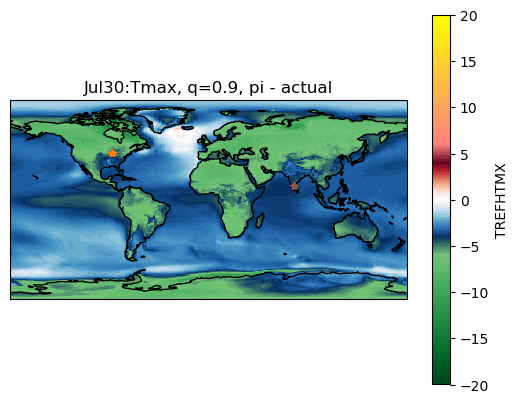

CPU times: user 5.72 s, sys: 399 ms, total: 6.11 s
Wall time: 6.18 s


In [318]:
%%time
#Quantile q=0.1
#Plot 3a
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_diff.sel(quantile=0.9,day=day).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                             cmap=cmap,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
plt.title(Day+':Tmax, q=0.9, pi - actual')
plt.show()

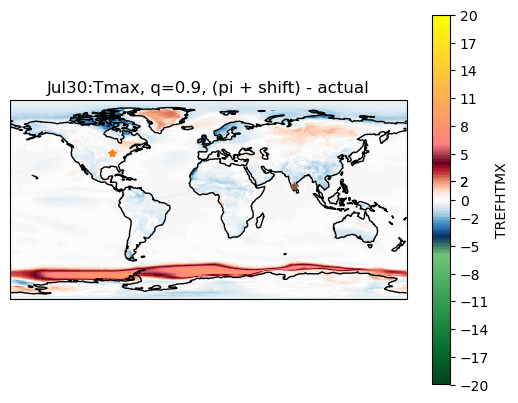

CPU times: user 6.76 s, sys: 418 ms, total: 7.18 s
Wall time: 6.94 s


In [319]:
%%time
#PLot 3b
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_reldiff1.sel(quantile=0.9,day=day).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                              cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
#plt.colorbar(sm,ax=ax,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
plt.title(Day+':Tmax, q=0.9, (pi + shift) - actual')
plt.show()

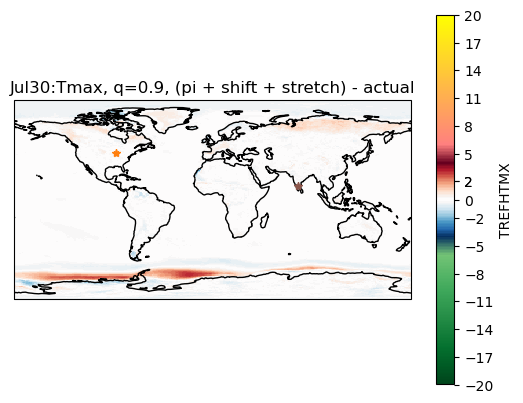

CPU times: user 4.37 s, sys: 244 ms, total: 4.62 s
Wall time: 4.59 s


In [320]:
%%time
#PLot 3c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_reldiff2.sel(quantile=0.9,day=day).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                              cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
#plt.colorbar(sm,ax=ax,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
plt.title(Day+':Tmax, q=0.9, (pi + shift + stretch) - actual')
plt.show()

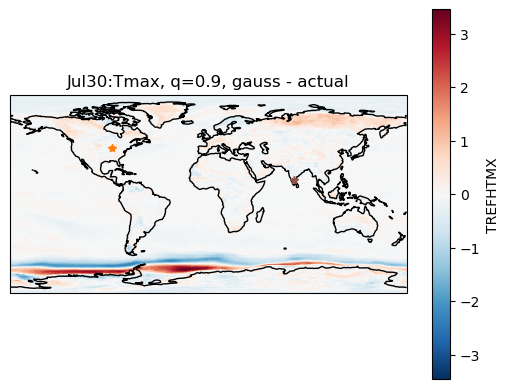

CPU times: user 5.8 s, sys: 323 ms, total: 6.12 s
Wall time: 6.01 s


In [321]:
%%time
#PLot 3c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_reldiff3.sel(quantile=0.9,day=day).plot(ax=ax,transform=cart.crs.PlateCarree())
                                                              #cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
#plt.colorbar(sm,ax=ax,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
plt.title(Day+':Tmax, q=0.9, gauss - actual')
plt.show()

In [322]:
################ seasonal plots  ###########

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

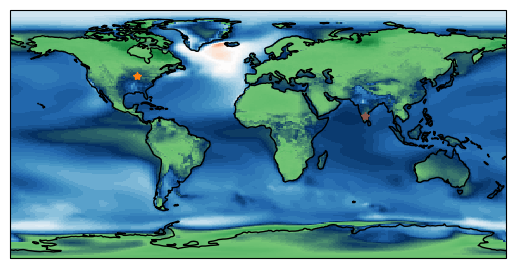

CPU times: user 13.8 s, sys: 841 ms, total: 14.7 s
Wall time: 14.3 s


In [323]:
%%time
#Plot 4a
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_diff.sel(quantile=0.9).mean({'day'}).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                     add_colorbar=False,cmap=cmap,norm=norm)
#plt.colorbar(sm,ax=ax,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
#plt.title('q=0.9, pi - actual, '+ season+' mean')
plt.title('')
plt.show()

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

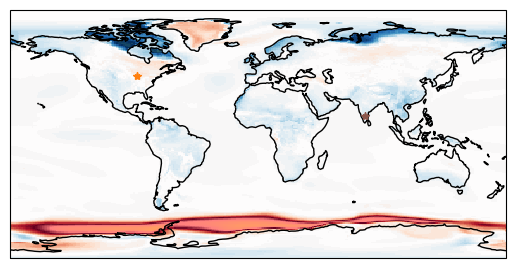

CPU times: user 9.99 s, sys: 457 ms, total: 10.4 s
Wall time: 10.5 s


In [324]:
%%time
#PLot 4b
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_reldiff1.sel(quantile=0.9).mean({'day'}).plot(ax=ax,transform=cart.crs.PlateCarree(),
                                                          add_colorbar=False,cmap=cmap,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title('q=0.9, (pi + shift) - actual, '+ season +' mean')
plt.title('')
plt.show()

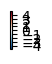

In [325]:
######## New colorbar only for shift + stretch and gaussian ############
x = 5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

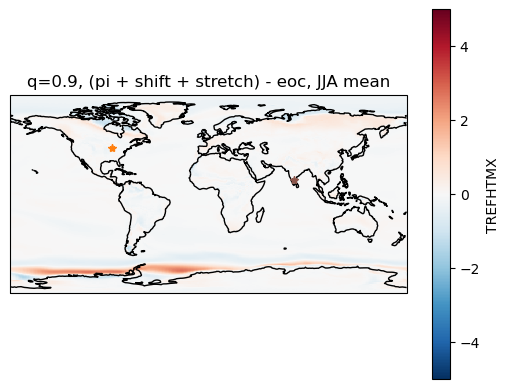

CPU times: user 8.57 s, sys: 407 ms, total: 8.98 s
Wall time: 9.02 s


In [326]:
%%time
#PLot 4c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_reldiff2.sel(quantile=0.9).mean({'day'}).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                         cmap=cmap,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
plt.title('q=0.9, (pi + shift + stretch) - eoc, '+ season +' mean')
#plt.title('')
plt.show()

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

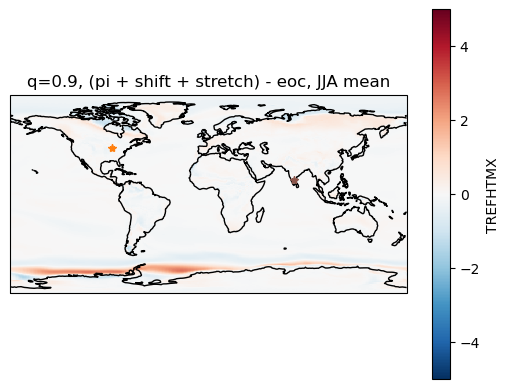

CPU times: user 12.2 s, sys: 720 ms, total: 12.9 s
Wall time: 12.6 s


In [327]:
%%time
#PLot 4c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmsc_season_err.sel(quantile=0.9).mean({'day'}).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                         cmap=cmap,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
plt.title('q=0.9, (pi + shift + stretch) - eoc, '+ season +' mean')
#plt.title('')
plt.show()

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

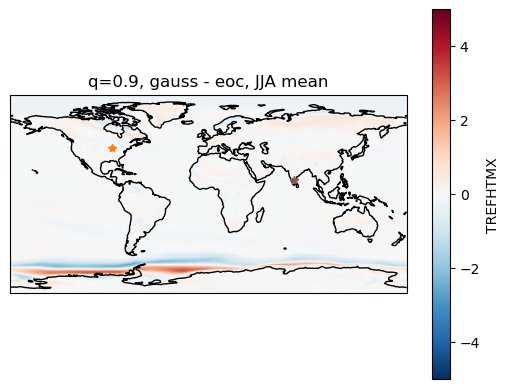

CPU times: user 15.4 s, sys: 1.64 s, total: 17 s
Wall time: 16.7 s


In [328]:
%%time
#PLot 4d
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_reldiff3.sel(quantile=0.9).mean({'day'}).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                         cmap=cmap,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
plt.title('q=0.9, gauss - eoc, '+ season +' mean')
#plt.title('')
plt.show()

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

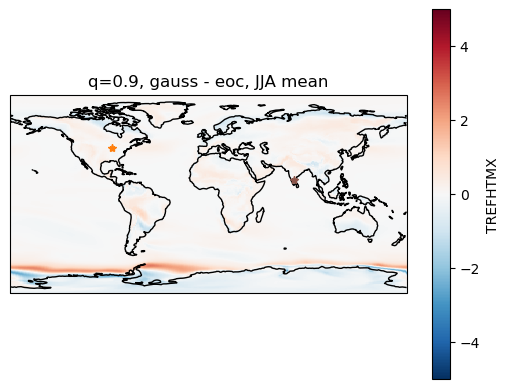

CPU times: user 13 s, sys: 661 ms, total: 13.6 s
Wall time: 13.3 s


In [329]:
%%time
#PLot 4d
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgauss_season_err.sel(quantile=0.9).mean({'day'}).plot(ax=ax,transform=cart.crs.PlateCarree(),\
                                                         cmap=cmap,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
plt.title('q=0.9, gauss - eoc, '+ season +' mean')
#plt.title('')
plt.show()

In [1]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting qgmsc_err
qgmsc_err.sel(quantile=0.9).plot(ax=axs[0], transform=cart.crs.PlateCarree(),add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
#axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_title('q=0.9, (pi + shift + stretch) - eoc, '+ season +' mean')

# Plotting da2
im = qgauss_err.sel(quantile=0.9).plot(ax=axs[1], transform=cart.crs.PlateCarree(), add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
#axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_title('q=0.9, gauss - eoc, '+ season +' mean')

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Errors')

#plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [330]:
####### Seasonal RMSEs over the globe ##########

In [331]:
qgmw_season_esq  = qgmw_season_diff**2
qgmc_season_esq  = qgmw_season_reldiff1**2
qgmsc_season_esq = qgmw_season_reldiff2**2

In [332]:
qgmw_season_mse  = qgmw_season_esq.mean('day')
qgmc_season_mse  = qgmc_season_esq.mean('day')
qgmsc_season_mse = qgmsc_season_esq.mean('day')
qgmsc_season_mse

<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288)>
dask.array<mean_agg-aggregate, shape=(101, 192, 288), dtype=float64, chunksize=(101, 20, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    int64 ...
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [333]:
qgmw_season_rmse   = np.sqrt(qgmw_season_mse)
qgmc_season_rmse   = np.sqrt(qgmc_season_mse)
qgmsc_season_rmse  = np.sqrt(qgmsc_season_mse)

In [334]:
%%time
qgmw_season_rmsepath  = cvals+'qgmw_'+season0+'_rmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_season_rmsepath  = cvals+'qgmc_'+season0+'_rmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_season_rmsepath = cvals+'qgmsc_'+season0+'_rmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##########################
# qgmw_season_rmse.to_dataset().to_zarr(qgmw_season_rmsepath,mode='w')
# qgmc_season_rmse.to_dataset().to_zarr(qgmc_season_rmsepath,mode='w')
# qgmsc_season_rmse.to_dataset().to_zarr(qgmsc_season_rmsepath,mode='w')

CPU times: user 20 µs, sys: 1e+03 ns, total: 21 µs
Wall time: 29.8 µs


In [335]:
%%time
################# Open and plot ################
qgmw_season_rmse  = xr.open_zarr(qgmw_season_rmsepath)
qgmc_season_rmse  = xr.open_zarr(qgmc_season_rmsepath)
qgmsc_season_rmse = xr.open_zarr(qgmsc_season_rmsepath)
qgmw_season_rmse  = qgmw_season_rmse.TREFHTMX
qgmc_season_rmse  = qgmc_season_rmse.TREFHTMX
qgmsc_season_rmse = qgmsc_season_rmse.TREFHTMX
qgmsc_season_rmse

CPU times: user 66.2 ms, sys: 17.6 ms, total: 83.8 ms
Wall time: 452 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288)>
dask.array<open_dataset-d5012c3b5646d503acd98b4eafeedd77TREFHTMX, shape=(101, 192, 288), dtype=float64, chunksize=(101, 20, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    int64 ...
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

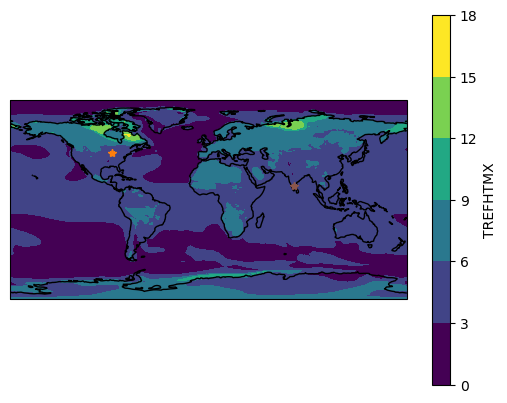

CPU times: user 2.92 s, sys: 239 ms, total: 3.16 s
Wall time: 3.06 s


In [336]:
%%time
#Plot 4a: RMSE
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_season_rmse.sel(quantile=0.9).plot.contourf(ax=ax,transform=cart.crs.PlateCarree())
#plt.colorbar(sm,ax=ax,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
#plt.title('q=0.9, pi - actual, '+ season+' mean')
plt.title('')
plt.show()

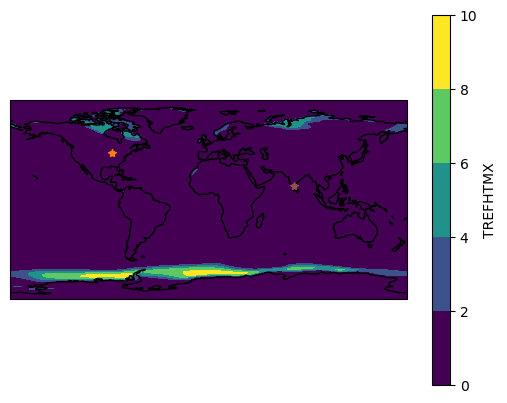

CPU times: user 1.15 s, sys: 68.9 ms, total: 1.22 s
Wall time: 1.33 s


In [337]:
%%time
#Plot 4b: RMSE
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmc_season_rmse.sel(quantile=0.9).plot.contourf(ax=ax,transform=cart.crs.PlateCarree())
#plt.colorbar(sm,ax=ax,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
#plt.title('q=0.9, pi - actual, '+ season+' mean')
plt.title('')
plt.show()

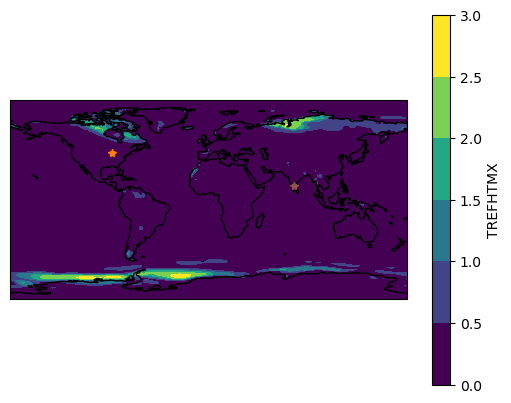

CPU times: user 1.02 s, sys: 64.9 ms, total: 1.09 s
Wall time: 1.26 s


In [338]:
%%time
#Plot 4c: RMSE
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmsc_season_rmse.sel(quantile=0.9).plot.contourf(ax=ax,transform=cart.crs.PlateCarree())
#plt.colorbar(sm,ax=ax,norm=norm)
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
ax.coastlines(color="black")
#plt.title(Day+',q=0.9,'+r'$\delta t_w - 0$')
#plt.title('q=0.9, pi - actual, '+ season+' mean')
plt.title('')
plt.show()

In [339]:
################## Take a zonal average (weighted mean over longitude) #########

In [340]:
weights      = np.cos(np.deg2rad(qgmw_season_diff.lat))
weights.name = "weights"

In [341]:
%%time
qgmw_season_diffw            = qgmw_season_diff.weighted(weights)
qgmw_season_reldiff1w        = qgmw_season_reldiff1.weighted(weights)
qgmw_season_reldiff2w        = qgmw_season_reldiff2.weighted(weights)

CPU times: user 0 ns, sys: 486 µs, total: 486 µs
Wall time: 493 µs


In [342]:
qgmw_season_zmean     = qgmw_season_diffw.mean('lon')
qgmc_season_zmean     = qgmw_season_reldiff1w.mean('lon')
qgmsc_season_zmean    = qgmw_season_reldiff2w.mean('lon')

In [343]:
qgmw_season_zme     = qgmw_season_zmean.mean('day')
qgmc_season_zme     = qgmc_season_zmean.mean('day')
qgmsc_season_zme    = qgmsc_season_zmean.mean('day')
qgmsc_season_zme    

<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192)>
dask.array<mean_agg-aggregate, shape=(101, 192), dtype=float64, chunksize=(101, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [344]:
%%time
qgmw_season_zmepath  = cvals+'qgmw_'+season0+'_zme'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_season_zmepath  = cvals+'qgmc_'+season0+'_zme'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_season_zmepath = cvals+'qgmsc_'+season0+'_zme'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##########################
# qgmw_season_zme.to_dataset().to_zarr(qgmw_season_zmepath,mode='w')
# qgmc_season_zme.to_dataset().to_zarr(qgmc_season_zmepath,mode='w')
# qgmsc_season_zme.to_dataset().to_zarr(qgmsc_season_zmepath,mode='w')

CPU times: user 414 µs, sys: 25 µs, total: 439 µs
Wall time: 446 µs


In [345]:
qgmw_season_zmepath   = xr.open_zarr(qgmw_season_zmepath)
qgmc_season_zmepath   = xr.open_zarr(qgmc_season_zmepath)
qgmsc_season_zmepath  = xr.open_zarr(qgmsc_season_zmepath)
qgmw_season_zmepath   = qgmw_season_zmepath.TREFHTMX
qgmc_season_zmepath   = qgmc_season_zmepath.TREFHTMX
qgmsc_season_zmepath  = qgmsc_season_zmepath.TREFHTMX

Text(0.5, 1.0, 'JJA:zonal mean, pi- actual')

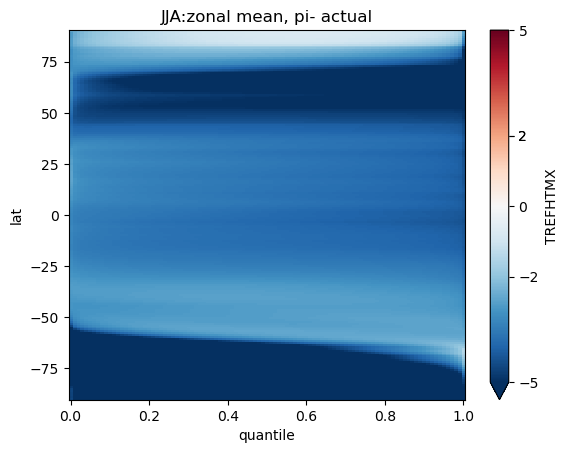

In [346]:
qgmw_season_zmepath.plot(x='quantile',y='lat',cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
plt.title(season + ':zonal mean, pi- actual')

Text(0.5, 1.0, 'JJA, zonal mean: pi- shift')

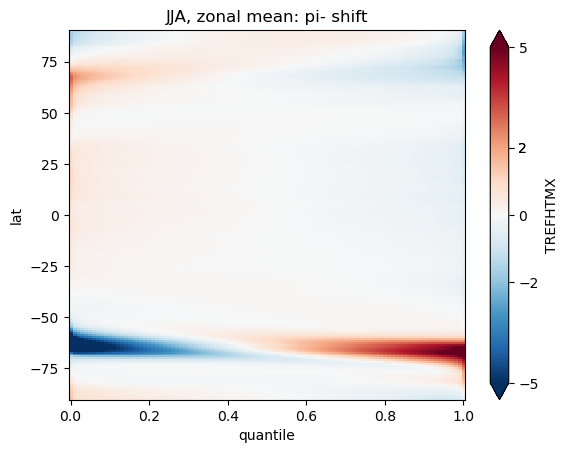

In [347]:
qgmc_season_zmepath.plot(x='quantile',y='lat',cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
plt.title(season + ', zonal mean: pi- shift')

Text(0.5, 1.0, 'JJA, zonal mean: pi- (shift + stretch)')

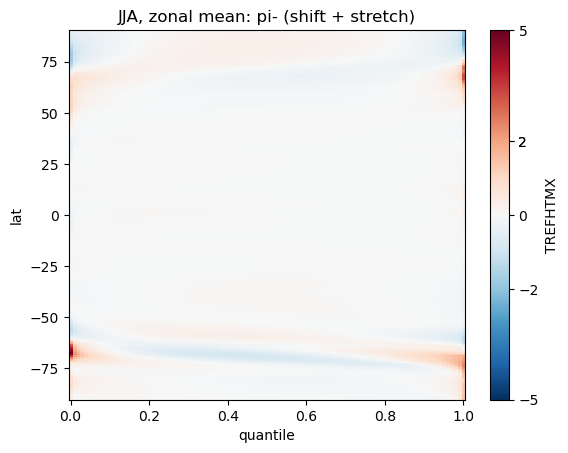

In [348]:
qgmsc_season_zmepath.plot(x='quantile',y='lat',cmap=cmap,norm=norm,cbar_kwargs={'ticks':ticks})
plt.title(season + ', zonal mean: pi- (shift + stretch)')

In [349]:
# %%time
# #PLot 4c
# ax            = plt.axes(projection=cart.crs.PlateCarree())
# qgmw_season_zme.plot(ax=ax,transform=cart.crs.PlateCarree())
# ax.coastlines(color="black")
# plt.title('Zonal mean')
# plt.show()

In [350]:
############# Compute area-weighted mean square of the above errors #####################

In [351]:
qgmw_season_esq  = qgmw_season_diff**2
qgmc_season_esq  = qgmw_season_reldiff1**2
qgmsc_season_esq = qgmw_season_reldiff2**2

In [352]:
weights      = np.cos(np.deg2rad(qgmw_season_esq.lat))
weights.name = "weights"

In [353]:
qgmw_seasonserror_weighted  = qgmw_season_esq.weighted(weights)
qgmc_seasonserror_weighted  = qgmc_season_esq.weighted(weights)
qgmsc_seasonserror_weighted = qgmsc_season_esq.weighted(weights)
qgmc_season_esq

,Array,Chunk
Bytes,3.83 GiB,2.31 MiB
Shape,"(101, 192, 288, 92)","(101, 20, 30, 5)"
Count,3801 Tasks,1900 Chunks
Type,float64,numpy.ndarray


In [354]:
qgmw_seasonserror_gmean   = qgmw_seasonserror_weighted.mean({'lat','lon'})
qgmc_seasonserror_gmean   = qgmc_seasonserror_weighted.mean({'lat','lon'})
qgmsc_seasonserror_gmean  = qgmsc_seasonserror_weighted.mean({'lat','lon'})
qgmc_seasonserror_gmean

<xarray.DataArray 'TREFHTMX' (quantile: 101, day: 92)>
dask.array<truediv, shape=(101, 92), dtype=float64, chunksize=(101, 5), chunktype=numpy.ndarray>
Coordinates:
  * day       (day) int64 152 153 154 155 156 157 ... 238 239 240 241 242 243
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [355]:
qgmw_season_gmse   = qgmw_seasonserror_gmean.mean({'day'})
qgmc_season_gmse   = qgmc_seasonserror_gmean.mean({'day'})
qgmsc_season_gmse  = qgmsc_seasonserror_gmean.mean({'day'})
qgmc_season_gmse

<xarray.DataArray 'TREFHTMX' (quantile: 101)>
dask.array<mean_agg-aggregate, shape=(101,), dtype=float64, chunksize=(101,), chunktype=numpy.ndarray>
Coordinates:
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [356]:
%%time
qgmw_season_grmse         = np.sqrt(qgmw_season_gmse)
qgmc_season_grmse         = np.sqrt(qgmc_season_gmse)
qgmsc_season_grmse        = np.sqrt(qgmsc_season_gmse)

CPU times: user 5.39 ms, sys: 1.03 ms, total: 6.42 ms
Wall time: 6.24 ms


In [357]:
%%time
qgmw_season_grmsepath  = cvals+'qgmw_'+season0+'_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_season_grmsepath  = cvals+'qgmc_'+season0+'_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_season_grmsepath = cvals+'qgmsc_'+season0+'_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##########################
# qgmw_season_grmse.to_dataset().to_zarr(qgmw_season_grmsepath,mode='w')
# qgmc_season_grmse.to_dataset().to_zarr(qgmc_season_grmsepath,mode='w')
# qgmsc_season_grmse.to_dataset().to_zarr(qgmsc_season_grmsepath,mode='w')

CPU times: user 46 µs, sys: 0 ns, total: 46 µs
Wall time: 55.3 µs


In [358]:
%%time
qgmw_season_grmse  = xr.open_zarr(qgmw_season_grmsepath)
qgmc_season_grmse  = xr.open_zarr(qgmc_season_grmsepath)
qgmsc_season_grmse = xr.open_zarr(qgmsc_season_grmsepath)
qgmw_season_grmse  = qgmw_season_grmse.TREFHTMX
qgmc_season_grmse  = qgmc_season_grmse.TREFHTMX
qgmsc_season_grmse = qgmsc_season_grmse.TREFHTMX

CPU times: user 33.8 ms, sys: 15.9 ms, total: 49.6 ms
Wall time: 180 ms


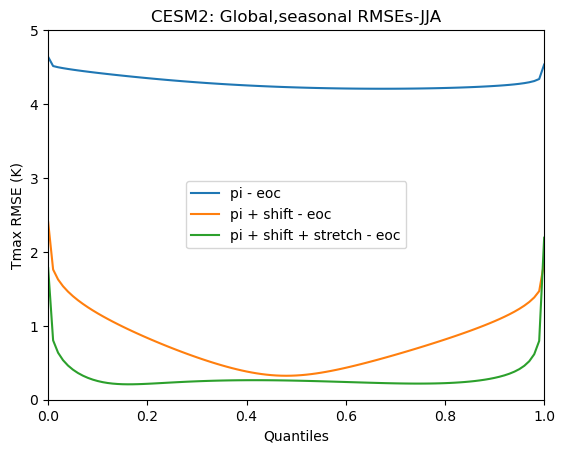

CPU times: user 634 ms, sys: 71.6 ms, total: 706 ms
Wall time: 798 ms


In [359]:
%%time
plt.plot(quants,qgmw_season_grmse,label='pi - eoc')
plt.plot(quants,qgmc_season_grmse,label='pi + shift - eoc',c='tab:orange')
plt.plot(quants,qgmsc_season_grmse,label='pi + shift + stretch - eoc',c='tab:green')
plt.legend(loc='center')
plt.title('CESM2: Global,seasonal RMSEs-'+season)
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,5.0)
plt.show()

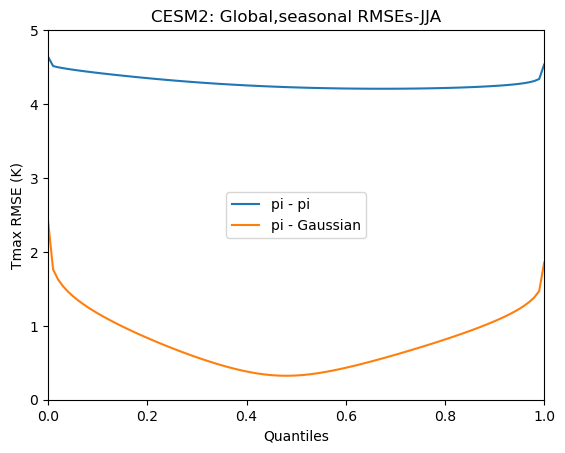

CPU times: user 327 ms, sys: 21.6 ms, total: 349 ms
Wall time: 385 ms


In [360]:
%%time
plt.plot(quants,qgmw_season_grmse,label='pi - pi', c='tab:blue')
plt.plot(quants,qgmc_season_grmse,label='pi - Gaussian',c='tab:orange')
plt.legend(loc='center')
plt.title('CESM2: Global,seasonal RMSEs-'+season)
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Quantiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,5.0)
plt.show()

In [361]:
%%time
season_error_redn = qgmsc_season_grmse.integrate('quantile')/qgmc_season_grmse.integrate('quantile')
season_error_redn.values

CPU times: user 93.3 ms, sys: 49.5 ms, total: 143 ms
Wall time: 266 ms


array(0.38285699)

In [362]:
qgmsc_season_grmse.integrate('quantile').values

array(0.29749931)

In [363]:
qgmc_season_grmse.integrate('quantile').values

array(0.77705074)

In [364]:
qgmsc_season_grmse.where(qgmsc_season_grmse<0.5).values

array([       nan,        nan,        nan,        nan, 0.4623713 ,
       0.40650195, 0.36179029, 0.32552034, 0.29589704, 0.27183512,
       0.25260467, 0.23758423, 0.22626362, 0.21816388, 0.21279854,
       0.20971466, 0.20846026, 0.20878519, 0.21026765, 0.21258375,
       0.21550875, 0.21881909, 0.22239354, 0.2261115 , 0.22982272,
       0.23349241, 0.23701974, 0.24040803, 0.24361749, 0.24660461,
       0.24936201, 0.25186348, 0.25416619, 0.2562018 , 0.25799309,
       0.25956506, 0.26087816, 0.26199098, 0.26287043, 0.26350485,
       0.26394581, 0.26419427, 0.2641911 , 0.26399593, 0.26362957,
       0.26307819, 0.26232668, 0.26145843, 0.26040973, 0.25922028,
       0.25787804, 0.25644743, 0.25487957, 0.25321753, 0.25147805,
       0.24965245, 0.24776677, 0.2457894 , 0.24375527, 0.24172247,
       0.23969606, 0.23763354, 0.23559504, 0.23356705, 0.23156894,
       0.2296225 , 0.22775734, 0.22596393, 0.22430568, 0.22278066,
       0.22142587, 0.22028509, 0.21935748, 0.21868085, 0.21827

In [365]:
qgmsc_season_grmse.where(qgmsc_season_grmse<1).values

array([       nan, 0.80289259, 0.63600063, 0.53493221, 0.4623713 ,
       0.40650195, 0.36179029, 0.32552034, 0.29589704, 0.27183512,
       0.25260467, 0.23758423, 0.22626362, 0.21816388, 0.21279854,
       0.20971466, 0.20846026, 0.20878519, 0.21026765, 0.21258375,
       0.21550875, 0.21881909, 0.22239354, 0.2261115 , 0.22982272,
       0.23349241, 0.23701974, 0.24040803, 0.24361749, 0.24660461,
       0.24936201, 0.25186348, 0.25416619, 0.2562018 , 0.25799309,
       0.25956506, 0.26087816, 0.26199098, 0.26287043, 0.26350485,
       0.26394581, 0.26419427, 0.2641911 , 0.26399593, 0.26362957,
       0.26307819, 0.26232668, 0.26145843, 0.26040973, 0.25922028,
       0.25787804, 0.25644743, 0.25487957, 0.25321753, 0.25147805,
       0.24965245, 0.24776677, 0.2457894 , 0.24375527, 0.24172247,
       0.23969606, 0.23763354, 0.23559504, 0.23356705, 0.23156894,
       0.2296225 , 0.22775734, 0.22596393, 0.22430568, 0.22278066,
       0.22142587, 0.22028509, 0.21935748, 0.21868085, 0.21827